<a href="https://colab.research.google.com/github/mahimna/625-744-Project/blob/main/625_744_Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
!pip install --upgrade bokeh==2.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.1
    Uninstalling bokeh-3.3.1:
      Successfully uninstalled bokeh-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.4 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.


In [ ]:
!pip install pandas-bokeh

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_bokeh
from scipy.stats import norm
import scipy.linalg as linalg
from datetime import date
from bokeh.models import NumeralTickFormatter, FixedTicker
from bokeh.plotting import figure, show, output_notebook

pandas_bokeh.output_notebook()

In [ ]:
def generate_gbm_path(initial_price, drift, volatility, num_steps, T):
  prices = []
  current_price = initial_price
  prices.append(initial_price)
  dt = T / num_steps
  while(T - dt > 0):
    dWt = np.random.normal(0, np.sqrt(dt))
    dYt = drift*dt + volatility*dWt
    current_price = current_price + current_price*dYt
    prices.append(current_price)
    T -= dt
  return prices

In [ ]:
def european_simulations(K, paths, r, T):
  prices = []
  for path in paths:
    price = np.exp(-r*T)*max(0, K - path[-1])
    prices.append(price)
  return np.mean(prices)

In [ ]:
def american_simulation(S, K, num_steps, paths, r, T):
  dt = T/num_steps;
  df = np.exp(-r * dt)
  exercise_payoff = [[0 for j in range(num_steps+1)] for i in range(paths)]
  for i in range(paths):
    for j in range(num_steps+1):
      exercise_payoff[i][j] = max(0, K-S[i][j])

  cf = [[0 for j in range(num_steps+1)] for i in range(paths)]

  for i in range(paths):
    cf[i][num_steps] = exercise_payoff[i][num_steps]

  for j in np.arange(num_steps-1,-1,-1):
    x_vals = []
    y_vals = []
    indices = []
    for i in range(paths):
      if (K-S[i][j]) > 0:
        indices.append(i)
        x_vals.append(S[i][j])
        y = 0
        for k in range(j+1,num_steps+1):
          if cf[i][k] > 0:
            y = cf[i][k]*np.exp(-dt*r*(k-j))
            break
        y_vals.append(y)

    if len(x_vals) > 0:
      poly_fit = np.polyfit(x_vals, y_vals, 2)
      poly_fit_evaluted = np.polyval(poly_fit, x_vals)

      for i in range(len(x_vals)):
        ind = indices[i]
        if (K-S[ind][j]) > poly_fit_evaluted[i]:
          cf[ind][j] = K-S[ind][j]
          for k in range(j+1,num_steps+1):
            cf[ind][k] = 0

  sum_dcf = 0
  for i in range(paths):
    for j in range(num_steps+1):
      sum_dcf += cf[i][j]*np.exp(-dt*r*j)

  return sum_dcf/paths

In [ ]:
def compute_american_prices_per_expiration(symbol):
  equity = yf.Ticker(symbol)
  curPrice = (float(equity.info['bid']) + float(equity.info['ask']))/2
  # curPrice = float(equity.info['currentPrice'])
  S0 = curPrice
  r = 0.0526
  M = 500

  optionInfo = []

  todayDate = date.today()

  for optionString in equity.options:
    splitOptionString = optionString.split('-')
    if int(splitOptionString[0]) > 2024:
      break
    optionChain = equity.option_chain(optionString)
    option = optionChain.puts[optionChain.puts['strike'] > curPrice].iloc[0]
    maturityDate = date(int(splitOptionString[0]),int(splitOptionString[1]), int(splitOptionString[2]))

    if maturityDate <= todayDate:
      continue

    delta = maturityDate - todayDate
    K = option.strike
    T = delta.days/365
    N = delta.days*10
    vol = float(option.impliedVolatility)

    price_paths = []

    for i in range(1, M):
      prices = generate_gbm_path(S0, r, vol, N, T)
      price_paths.append(prices)

    value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
    optionInfo.append((optionString, K, (option.bid+option.ask)/2, value))

  return optionInfo

In [ ]:
def compute_american_prices_per_strike(symbol, optionString):
  equity = yf.Ticker(symbol)
  curPrice = (float(equity.info['bid']) + float(equity.info['ask']))/2
  print(curPrice)
  S0 = curPrice
  r = 0.0526
  M = 500

  optionInfo = []

  todayDate = date.today()

  optionChain = equity.option_chain(optionString)

  splitOptionString = optionString.split('-')
  maturityDate = date(int(splitOptionString[0]),int(splitOptionString[1]), int(splitOptionString[2]))

  delta = maturityDate - todayDate
  T = delta.days/365
  N = delta.days*10

  for i in range(len(optionChain.puts)):

    option = optionChain.puts.iloc[i]
    print(option)
    K = option.strike
    vol = float(option.impliedVolatility)

    price_paths = []

    for i in range(1, M):
      prices = generate_gbm_path(S0, r, vol, N, T)
      price_paths.append(prices)

    value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
    optionInfo.append((optionString, K, (option.bid+option.ask)/2, value))

  return optionInfo

In [ ]:
def compute_european_prices_per_expiration(symbol):
  equity = yf.Ticker(symbol)
  curPrice = (float(equity.info['bid']) + float(equity.info['ask']))/2
  # curPrice = 4549.34
  S0 = curPrice
  r = 0.0526
  M = 500

  optionInfo = []

  todayDate = date.today()

  for optionString in equity.options:
    splitOptionString = optionString.split('-')
    if int(splitOptionString[0]) > 2024:
      break
    optionChain = equity.option_chain(optionString)
    option = optionChain.puts[optionChain.puts['strike'] > curPrice].iloc[0]
    maturityDate = date(int(splitOptionString[0]),int(splitOptionString[1]), int(splitOptionString[2]))

    if maturityDate <= todayDate:
      continue

    delta = maturityDate - todayDate
    K = option.strike
    T = delta.days/365
    N = delta.days*40
    vol = float(option.impliedVolatility)

    price_paths = []

    for i in range(1, M):
      prices = generate_gbm_path(S0, r, vol, N, T)
      price_paths.append(prices)

    value = european_simulations(K=K, paths=price_paths, r=r, T=T)
    optionInfo.append((optionString, K, (option.bid+option.ask)/2, value))

  return optionInfo

In [ ]:
def compute_european_prices_per_strike(symbol, optionString):
  equity = yf.Ticker(symbol)
  curPrice = (float(equity.info['bid']) + float(equity.info['ask']))/2
  print(curPrice)
  S0 = curPrice
  r = 0.0526
  M = 500

  optionInfo = []

  todayDate = date.today()

  optionChain = equity.option_chain(optionString)

  splitOptionString = optionString.split('-')
  maturityDate = date(int(splitOptionString[0]),int(splitOptionString[1]), int(splitOptionString[2]))

  delta = maturityDate - todayDate
  T = delta.days/365
  N = delta.days*10

  for i in range(len(optionChain.puts)):

    option = optionChain.puts.iloc[i]
    print(option)

    K = option.strike
    vol = float(option.impliedVolatility)

    price_paths = []

    for i in range(1, M):
      prices = generate_gbm_path(S0, r, vol, N, T)
      price_paths.append(prices)

    value = european_simulations(K=K, paths=price_paths, r=r, T=T)
    optionInfo.append((optionString, K, (option.bid+option.ask)/2, value))

  return optionInfo

In [ ]:
optionInfoAmzn = compute_american_prices_per_expiration('AMZN')

<ipython-input-116-955cd90785c7>:36: RankWarning: Polyfit may be poorly conditioned
  value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
<ipython-input-116-955cd90785c7>:36: RankWarning: Polyfit may be poorly conditioned
  value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
<ipython-input-116-955cd90785c7>:36: RankWarning: Polyfit may be poorly conditioned
  value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
<ipython-input-116-955cd90785c7>:36: RankWarning: Polyfit may be poorly conditioned
  value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
<ipython-input-116-955cd90785c7>:36: RankWarning: Polyfit may be poorly conditioned
  value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_steps=N-1)
<ipython-input-116-955cd90785c7>:36: RankWarning: Polyfit may be poorly conditioned
  value = american_simulation(S=price_paths, K=K, paths=i, r=r, T=T, num_ste

In [ ]:
optionInfoSPX = compute_european_prices_per_expiration('^SPX')

In [ ]:
optionInfoAmzn

[('2023-12-08', 145.0, 1.455, 1.2870225553123238),
 ('2023-12-15', 145.0, 2.525, 2.761675616542522),
 ('2023-12-22', 145.0, 3.0999999999999996, 3.0592891561981634),
 ('2023-12-29', 145.0, 3.5250000000000004, 3.3943014347240807),
 ('2024-01-05', 145.0, 4.0, 3.848462834051642),
 ('2024-01-12', 145.0, 4.550000000000001, 4.6916207336342195),
 ('2024-01-19', 145.0, 4.925000000000001, 4.5006354477224475),
 ('2024-02-16', 145.0, 7.65, 7.375767993810344),
 ('2024-03-15', 145.0, 8.55, 8.72780371534493),
 ('2024-04-19', 145.0, 9.524999999999999, 7.794395391400903),
 ('2024-06-21', 145.0, 11.875, 10.512638117963933),
 ('2024-07-19', 145.0, 12.325, 9.421994904779364),
 ('2024-09-20', 145.0, 14.025, 11.914724834381676)]

In [ ]:
dates = [tp[0] for tp in optionInfoAmzn]
lastPrice = [tp[2] for tp in optionInfoAmzn]
simulationPrice = [tp[3] for tp in optionInfoAmzn]
error = [abs(tp[2]-tp[3]) for tp in optionInfoAmzn]

In [ ]:
amzn_data = pd.DataFrame(
    {'dates': dates,
     'lastPrice': lastPrice,
     'simulationPrice': simulationPrice,
     'abs_error': error
    });

<Axes: xlabel='dates'>

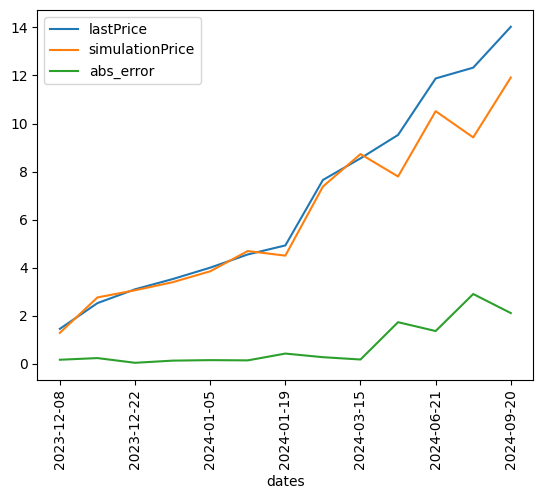

In [ ]:
amzn_data.plot.line(x='dates',rot=90)

In [ ]:
optionInfoSPX

[('2023-12-07', 4550.0, 9.0, 6.594184059599589),
 ('2023-12-08', 4550.0, 16.65, 13.996940811577495),
 ('2023-12-11', 4550.0, 19.65, 17.067597798347457),
 ('2023-12-12', 4550.0, 24.0, 20.672798898117616),
 ('2023-12-13', 4550.0, 28.85, 25.37112383892921),
 ('2023-12-14', 4550.0, 30.85, 31.14243637214746),
 ('2023-12-15', 4550.0, 31.45, 29.41600951264022),
 ('2023-12-18', 4550.0, 34.400000000000006, 30.112305215840465),
 ('2023-12-19', 4550.0, 35.7, 29.939505997451597),
 ('2023-12-20', 4550.0, 37.2, 29.529222414438973),
 ('2023-12-21', 4550.0, 37.7, 35.66592159747494),
 ('2023-12-22', 4550.0, 39.0, 33.19535273979186),
 ('2023-12-26', 4550.0, 40.400000000000006, 38.160890682890894),
 ('2023-12-27', 4550.0, 41.75, 34.01799191505365),
 ('2023-12-28', 4550.0, 42.099999999999994, 33.66608983658361),
 ('2023-12-29', 4550.0, 43.55, 33.742483367215435),
 ('2024-01-02', 4550.0, 45.25, 40.42362822945682),
 ('2024-01-03', 4550.0, 46.7, 39.238283464751284),
 ('2024-01-04', 4550.0, 47.75, 38.63508749

In [ ]:
dates = [tp[0] for tp in optionInfoSPX]
lastPrice = [tp[2] for tp in optionInfoSPX]
simulationPrice = [tp[3] for tp in optionInfoSPX]
error = [abs(tp[2]-tp[3]) for tp in optionInfoSPX]

In [ ]:
spx_data = pd.DataFrame(
    {'dates': dates,
     'lastPrice': lastPrice,
     'simulationPrice': simulationPrice,
     'abs_error': error
    });

<Axes: xlabel='dates'>

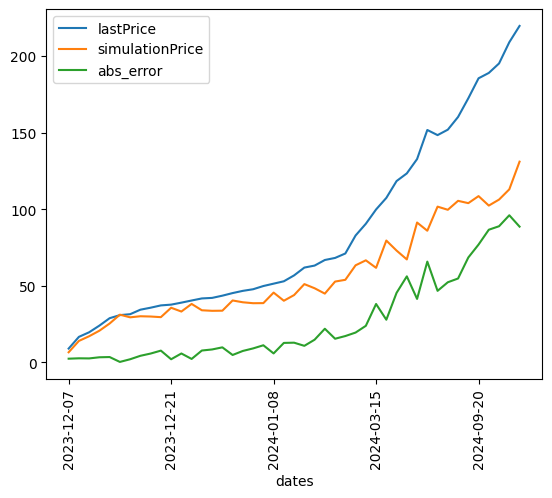

In [ ]:
spx_data.plot.line(x='dates',rot=90)

In [ ]:
spx_data

,dates,lastPrice,simulationPrice,abs_error
0,2023-12-07,9.00,6.594184,2.405816
1,2023-12-08,16.65,13.996941,2.653059
2,2023-12-11,19.65,17.067598,2.582402
3,2023-12-12,24.00,20.672799,3.327201
4,2023-12-13,28.85,25.371124,3.478876
5,2023-12-14,30.85,31.142436,0.292436
6,2023-12-15,31.45,29.416010,2.033990
7,2023-12-18,34.40,30.112305,4.287695
8,2023-12-19,35.70,29.939506,5.760494
9,2023-12-20,37.20,29.529222,7.670778


In [ ]:
optionInfoAmznStrikes = compute_american_prices_per_strike('AMZN', '2024-03-15')

In [ ]:
optionInfoSPXStrikes = compute_european_prices_per_strike('^SPX', '2024-03-15')

In [ ]:
strikes = [tp[1] for tp in optionInfoAmznStrikes]
lastPrice = [tp[2] for tp in optionInfoAmznStrikes]
simulationPrice = [tp[3] for tp in optionInfoAmznStrikes]
error = [abs(tp[2]-tp[3]) for tp in optionInfoAmznStrikes]

In [ ]:
amzn_strikes_data = pd.DataFrame(
    {'strikes': strikes,
     'lastPrice': lastPrice,
     'simulationPrice': simulationPrice,
     'abs_error': error
    });

<Axes: xlabel='strikes'>

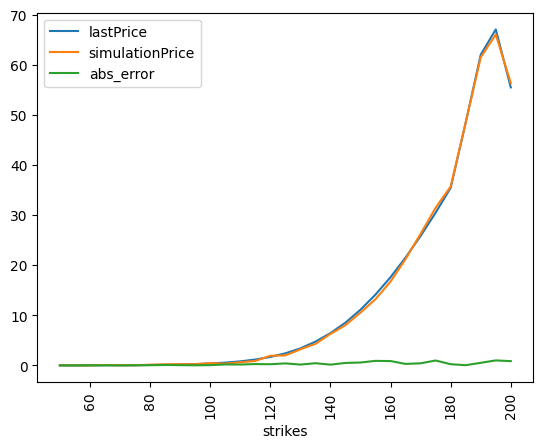

In [ ]:
amzn_strikes_data.plot.line(x='strikes',rot=90)

In [ ]:
strikes = [tp[1] for tp in optionInfoSPXStrikes]
lastPrice = [tp[2] for tp in optionInfoSPXStrikes]
simulationPrice = [tp[3] for tp in optionInfoSPXStrikes]
error = [abs(tp[2]-tp[3]) for tp in optionInfoSPXStrikes]

In [ ]:
np.mean(error)

18.09646188838165

In [ ]:
spx_strikes_data = pd.DataFrame(
    {'strikes': strikes,
     'lastPrice': lastPrice,
     'simulationPrice': simulationPrice,
     'abs_error': error
    });

<Axes: xlabel='strikes'>

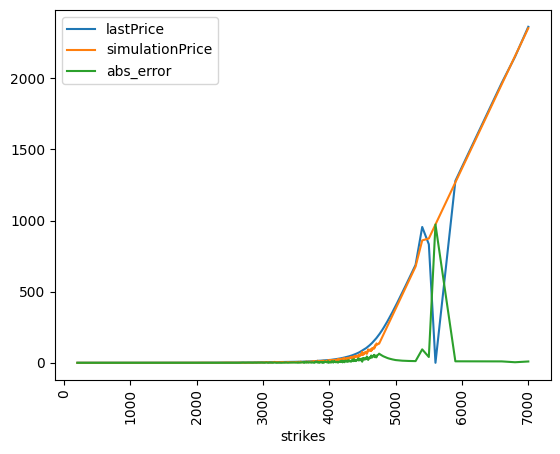

In [ ]:
spx_strikes_data.plot.line(x='strikes',rot=90)